Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at SenseTime/deformable-detr-single-scale-dc5 were not used when initializing DeformableDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


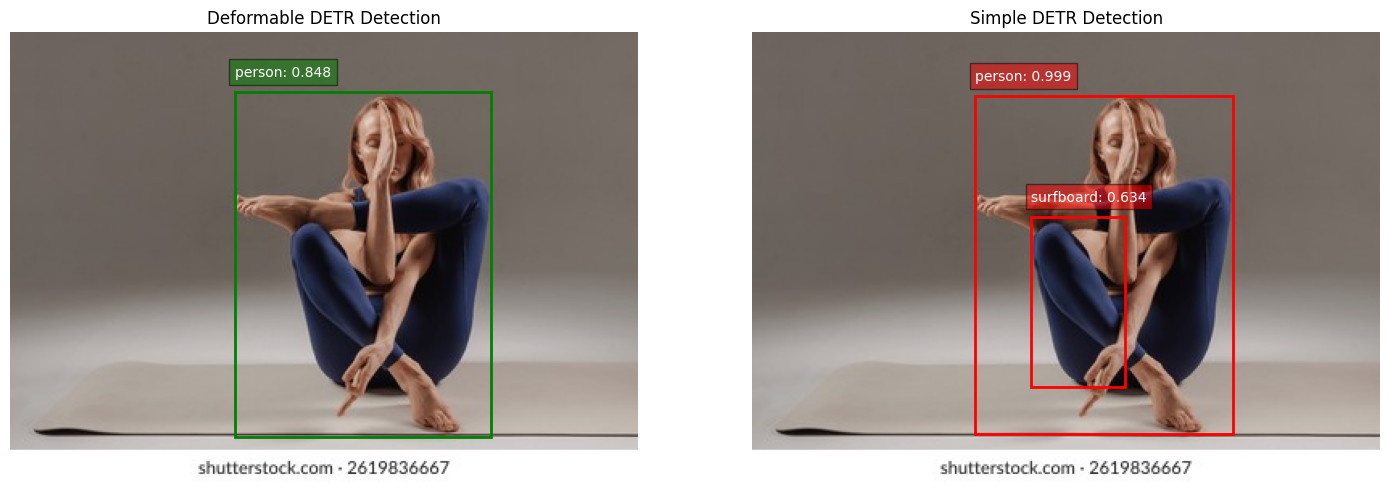

In [2]:
from transformers import AutoImageProcessor, DeformableDetrForObjectDetection
import torch
from PIL import Image
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import DetrImageProcessor, DetrForObjectDetection

# Load and process the image
url = "https://www.shutterstock.com/image-photo/flexible-woman-performing-complex-yoga-260nw-2619836667.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

# Deformable DETR setup
deformable_processor = AutoImageProcessor.from_pretrained("SenseTime/deformable-detr-single-scale-dc5")
deformable_model = DeformableDetrForObjectDetection.from_pretrained("SenseTime/deformable-detr-single-scale-dc5")

# Simple DETR setup
simple_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
simple_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

# Prepare inputs for both models
deformable_inputs = deformable_processor(images=image, return_tensors="pt")
simple_inputs = simple_processor(images=image, return_tensors="pt")

# Get outputs from both models
with torch.no_grad():
    deformable_outputs = deformable_model(**deformable_inputs)
    simple_outputs = simple_model(**simple_inputs)

# Post-process outputs (bounding boxes and class logits) with threshold > 0.7
target_sizes = torch.tensor([image.size[::-1]])
deformable_results = deformable_processor.post_process_object_detection(deformable_outputs, target_sizes=target_sizes, threshold=0.5)[0]
simple_results = simple_processor.post_process_object_detection(simple_outputs, target_sizes=target_sizes, threshold=0.5)[0]

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Display original image on both subplots
ax1.imshow(image)
ax2.imshow(image)

# Draw deformable DETR detections on the left subplot
for score, label, box in zip(deformable_results["scores"], deformable_results["labels"], deformable_results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='g', facecolor='none')
    ax1.add_patch(rect)
    ax1.text(box[0], box[1] - 10, f"{deformable_model.config.id2label[label.item()]}: {score.item():.3f}",
              bbox=dict(facecolor='green', alpha=0.5), fontsize=10, color='white')

# Draw simple DETR detections on the right subplot
for score, label, box in zip(simple_results["scores"], simple_results["labels"], simple_results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
    ax2.add_patch(rect)
    ax2.text(box[0], box[1] - 10, f"{simple_model.config.id2label[label.item()]}: {score.item():.3f}",
              bbox=dict(facecolor='red', alpha=0.5), fontsize=10, color='white')

# Set titles
ax1.set_title("Deformable DETR Detection")
ax2.set_title("Simple DETR Detection")
for ax in [ax1, ax2]:
    ax.axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()